In [ ]:
!pip install kaggle


In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset


In [2]:
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 33.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 31.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 23.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 54.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 12.4 MB/s eta 0:00:00
  

In [ ]:
import zipfile

with zipfile.ZipFile('breast-ultrasound-images-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('breast_ultrasound_images')


In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def load_images_and_masks(base_data_dir, sub_dirs, img_size=(128, 128)):
    images = []
    masks = []
    
    for sub_dir in sub_dirs:
        data_dir = os.path.join(base_data_dir, sub_dir)
        
        if not os.path.exists(data_dir):
            print(f"Directory {data_dir} not found")
            continue
        
        files = sorted(os.listdir(data_dir))
        
        for file in files:
            if '_mask' in file:
                continue
            img_path = os.path.join(data_dir, file)
            mask_path = img_path.replace('.png', '_mask.png')
            
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            
            # Load mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize to [0, 1]
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            
            images.append(img)
            masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load the images and masks from all subdirectories
dataset_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
sub_dirs = ['benign', 'malignant', 'normal']
images, masks = load_images_and_masks(dataset_dir, sub_dirs)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')


2024-07-10 19:32:59.664687: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 19:32:59.680555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 19:32:59.705697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 19:32:59.705728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 19:32:59.720903: I tensorflow/core/platform/cpu_feature_gua

Training samples: 624
Validation samples: 156


In [3]:
# Define the metrics functions
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def iou(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

def precision(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_positives = tf.reduce_sum(y_true_f * y_pred_f)
    predicted_positives = tf.reduce_sum(y_pred_f)
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_positives = tf.reduce_sum(y_true_f * y_pred_f)
    possible_positives = tf.reduce_sum(y_true_f)
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + tf.keras.backend.epsilon()))

def specificity(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_negatives = tf.reduce_sum((1 - y_true_f) * (1 - y_pred_f))
    possible_negatives = tf.reduce_sum(1 - y_true_f)
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def sensitivity(y_true, y_pred):
    return recall(y_true, y_pred)


In [4]:
# Build the U-Net model
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[
        'accuracy', dice_coefficient, iou, precision, recall, f1_score, specificity, sensitivity])

    return model

# Build the model
model = unet_model()

# Display the model summary
model.summary()

2024-07-10 19:38:55.275715: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 19:38:55.318881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 19:38:55.319119: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1720640369.915314    2652 service.cc:145] XLA service 0x7f5150020bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720640369.915352    2652 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-10 19:39:30.055723: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-10 19:39:30.641514: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8903


 1/78 ━━━━━━━━━━━━━━━━━━━━ 36:32 28s/step - accuracy: 0.0538 - dice_coefficient: 0.0562 - f1_score: 0.0562 - iou: 0.0289 - loss: 0.7006 - precision: 0.0298 - recall: 0.5040 - sensitivity: 0.5040 - specificity: 0.4961

I0000 00:00:1720640393.578904    2652 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8418 - dice_coefficient: 0.0976 - f1_score: 0.0976 - iou: 0.0523 - loss: 0.4437 - precision: 0.0792 - recall: 0.2447 - sensitivity: 0.2447 - specificity: 0.7531
Epoch 1: val_loss improved from inf to 0.23185, saving model to model-unet.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 47s 245ms/step - accuracy: 0.8425 - dice_coefficient: 0.0980 - f1_score: 0.0980 - iou: 0.0525 - loss: 0.4420 - precision: 0.0799 - recall: 0.2440 - sensitivity: 0.2440 - specificity: 0.7544 - val_accuracy: 0.9225 - val_dice_coefficient: 0.1800 - val_f1_score: 0.1800 - val_iou: 0.0998 - val_loss: 0.2318 - val_precision: 0.1519 - val_recall: 0.2436 - val_sensitivity: 0.2436 - val_specificity: 0.8897 - learning_rate: 1.0000e-04
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9231 - dice_coefficient: 0.1851 - f1_score: 0.1851 - iou: 0.1031 - loss: 0.2119 - precision: 0.2066 - recall: 0.2032 - sensitivity: 0.2032 - specificity: 0.9308
Epoch 2: val_loss im

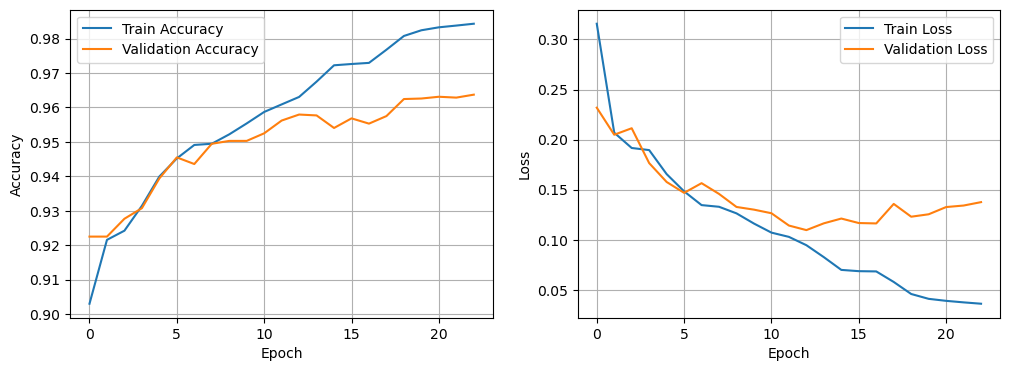

In [5]:

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model-unet.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

# Save the final model
model.save('unet_unaugmented_model.keras')

# Plot the training and validation accuracy and loss at each epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

# Calculate metrics on validation data
y_pred_val = model.predict(X_val)
y_pred_val = (y_pred_val > 0.5).astype(int)  # Apply threshold to get binary predictions

# Ensure masks_actual is also binary
masks_actual = (y_val > 0.5).astype(int).flatten()
masks_pred = y_pred_val.flatten()

# Calculate the metrics
accuracy = accuracy_score(masks_actual, masks_pred) * 100
precision = precision_score(masks_actual, masks_pred) * 100
recall = recall_score(masks_actual, masks_pred) * 100
f1 = f1_score(masks_actual, masks_pred) * 100
conf_matrix = confusion_matrix(masks_actual, masks_pred)
specificity = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])) * 100
dice = (2 * np.sum(masks_actual * masks_pred) / (np.sum(masks_actual) + np.sum(masks_pred))) * 100
sensitivity = recall  # Recall is the same as sensitivity in this context

metrics = pd.DataFrame({
    'Metrics For Validation Data': ['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Specificity', 'Dice Score', 'Sensitivity'],
    'Value': [accuracy, precision, recall, f1, specificity, dice, sensitivity]
})

print(metrics)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
  Metrics For Validation Data      Value
0              Accuracy Score  96.478389
1             Precision Score  81.408150
2                Recall Score  69.881233
3                    F1 Score  75.205567
4                 Specificity  98.679341
5                  Dice Score  75.205567
6                 Sensitivity  69.881233


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


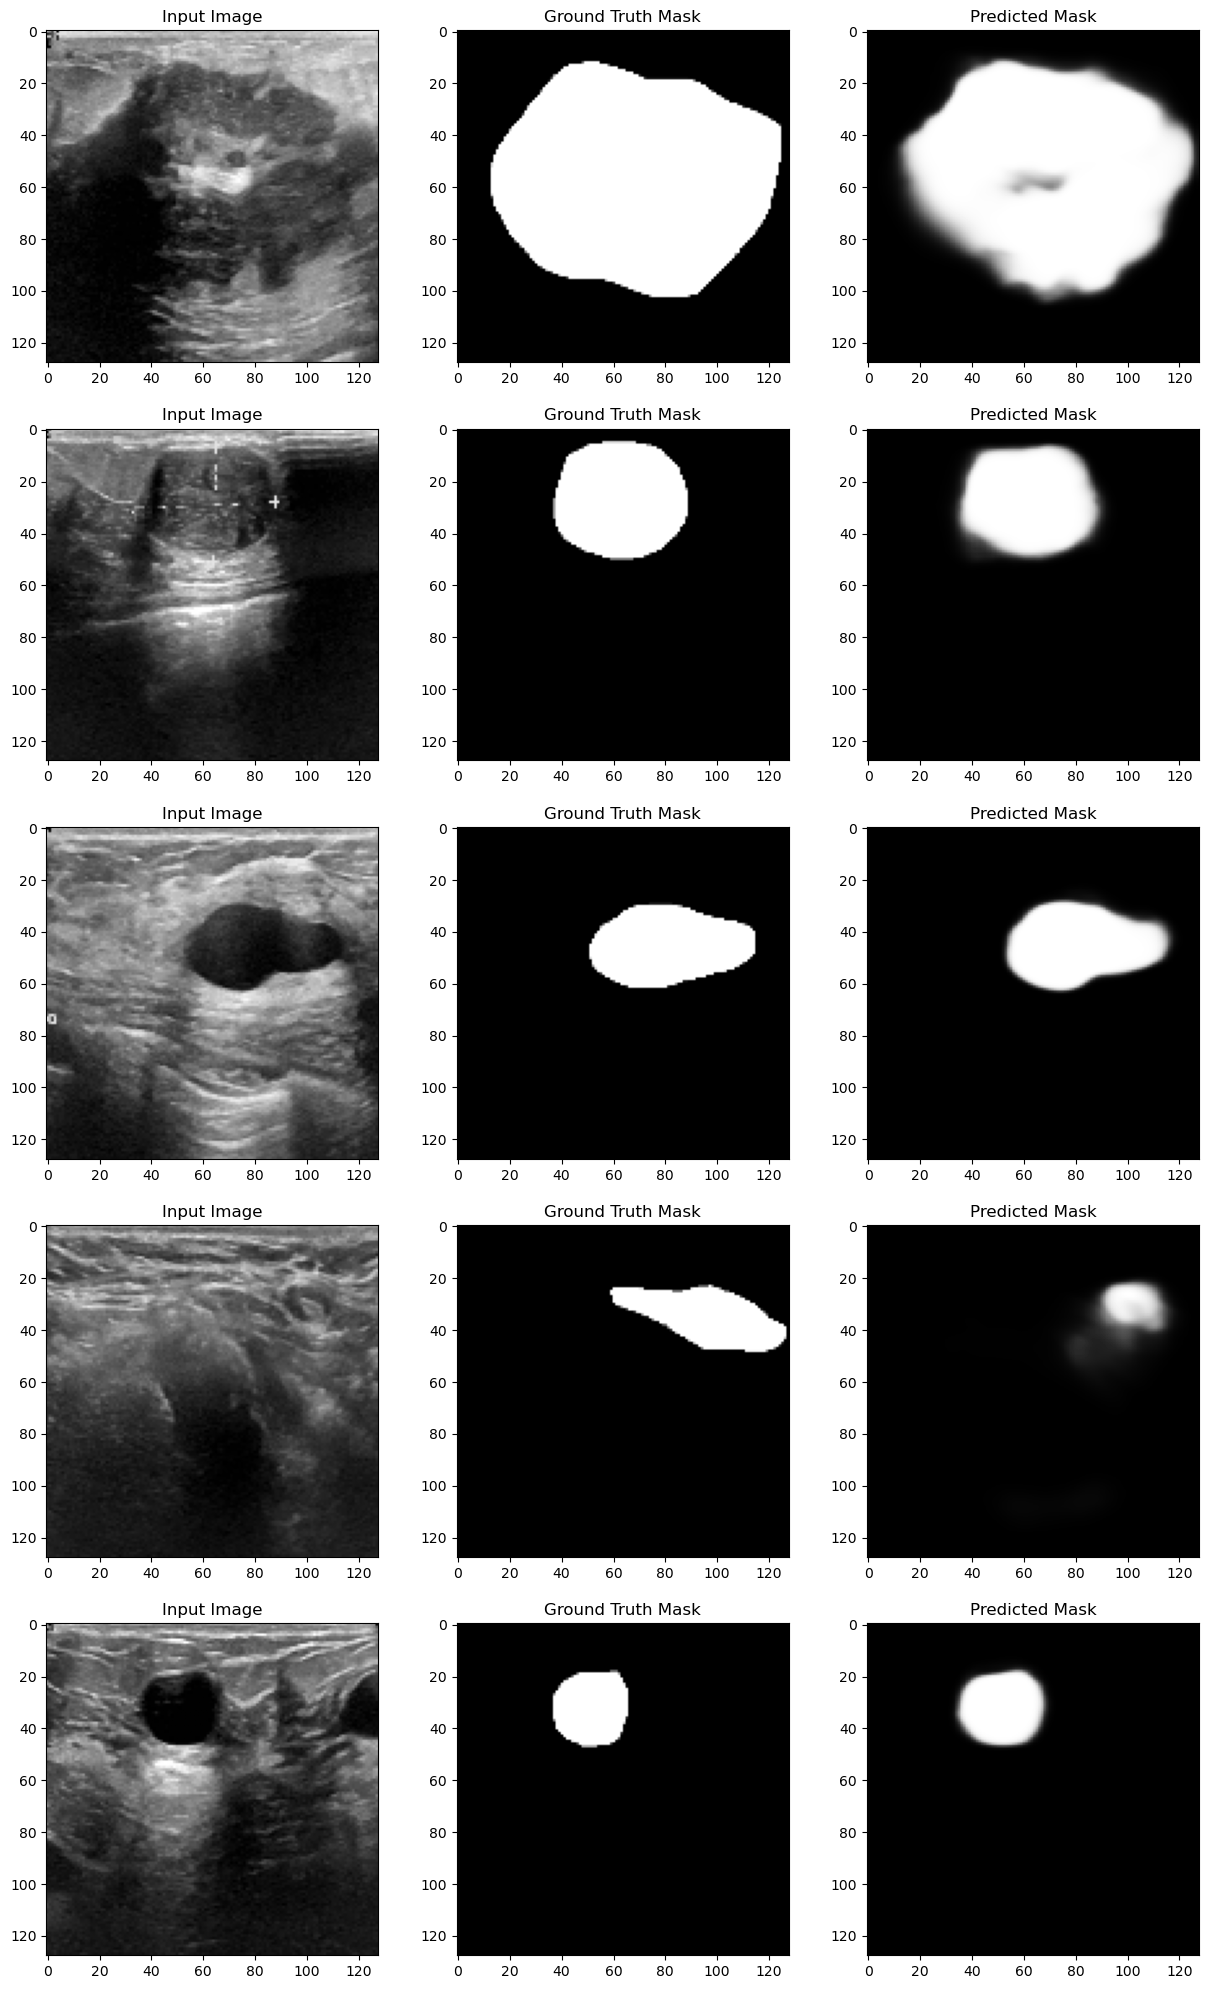

In [10]:
import matplotlib.pyplot as plt
import random

def plot_predictions(model, X_val, y_val, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        idx = random.randint(0, len(X_val) - 1)
        img = X_val[idx]
        true_mask = y_val[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title('Input Image')
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
    
    plt.show()

# Assuming the model and validation data (X_val, y_val) are already loaded
plot_predictions(model, X_val, y_val)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4798 - loss: 1.2949 - val_accuracy: 0.5385 - val_loss: 1.0611 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - accuracy: 0.5496 - loss: 1.0234 - val_accuracy: 0.5385 - val_loss: 1.0142 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.5736 - loss: 0.9767 - val_accuracy: 0.5385 - val_loss: 1.0034 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5513 - loss: 0.9881 - val_accuracy: 0.5385 - val_loss: 1.0063 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.5803 - loss: 0.9720 - val_accuracy: 0.5385 - val_loss: 1.0014 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5716 - loss: 0.9826 - val_accuracy: 0.5385 - val_loss: 1.0019 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5621 - loss: 0.9819 - va

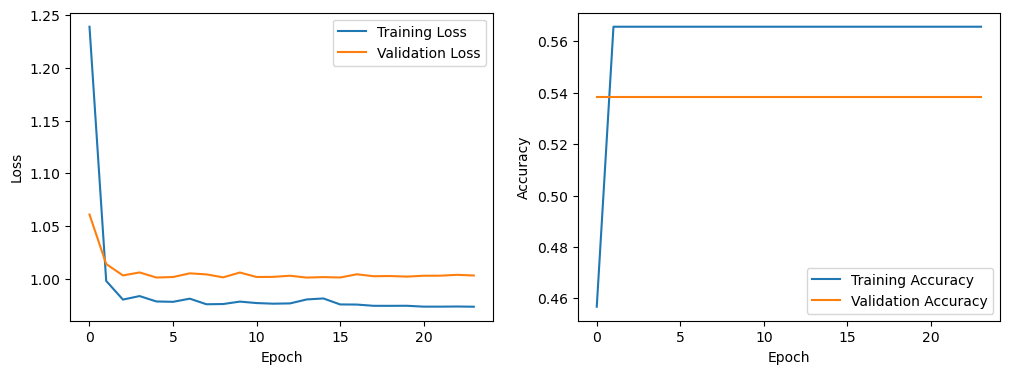

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
Accuracy Score: 53.85
Precision Score: 28.99
Recall Score: 53.85
F1 Score: 37.69
Specificity: nan
Dice Score: 37.69
Sensitivity: 53.85


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

def load_images_and_labels(base_data_dir, sub_dirs, img_size=(128, 128)):
    images = []
    labels = []
    
    for label, sub_dir in enumerate(sub_dirs):
        data_dir = os.path.join(base_data_dir, sub_dir)
        
        if not os.path.exists(data_dir):
            print(f"Directory {data_dir} not found")
            continue
        
        files = sorted(os.listdir(data_dir))
        
        for file in files:
            if '_mask' in file:
                continue
            img_path = os.path.join(data_dir, file)
            
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

# Load the images and labels from all subdirectories
dataset_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
sub_dirs = ['benign', 'malignant', 'normal']
images, labels = load_images_and_labels(dataset_dir, sub_dirs)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

def build_unet_classification_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Flatten for classification
    f = Flatten()(c5)
    d1 = Dense(512, activation='relu')(f)
    d2 = Dense(256, activation='relu')(d1)
    d3 = Dense(128, activation='relu')(d2)
    outputs = Dense(num_classes, activation='softmax')(d3)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = X_train.shape[1:]
num_classes = len(sub_dirs)
model = build_unet_classification_model(input_shape, num_classes)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_unet_classification_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predict the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred_classes)
precision = precision_score(y_val, y_pred_classes, average='weighted')
recall = recall_score(y_val, y_pred_classes, average='weighted')
f1 = f1_score(y_val, y_pred_classes, average='weighted')

# Calculate confusion matrix to derive specificity and sensitivity
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Ensure the confusion matrix has the correct shape
if conf_matrix.shape == (2, 2):
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall  # Sensitivity is the same as recall for the positive class
else:
    specificity = np.nan
    sensitivity = recall

# Dice score is typically used for segmentation, but for classification, it's the same as F1 score
dice_score = f1

# Display the metrics
print(f"Accuracy Score: {accuracy * 100:.2f}")
print(f"Precision Score: {precision * 100:.2f}")
print(f"Recall Score: {recall * 100:.2f}")
print(f"F1 Score: {f1 * 100:.2f}")
print(f"Specificity: {specificity * 100:.2f}")
print(f"Dice Score: {dice_score * 100:.2f}")
print(f"Sensitivity: {sensitivity * 100:.2f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 16, 16,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ up_sampling2d_4[

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1720696177.581328   17189 service.cc:145] XLA service 0x7f4c080016b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720696177.581361   17189 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-11 11:09:37.703985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-11 11:09:38.921198: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8903
2024-07-11 11:09:46.556279: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=1,k4=2,k5=1,k6=0,k7=0,k19=0} for conv (f32[8,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,128,128]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_que

 1/13 ━━━━━━━━━━━━━━━━━━━━ 9:17 46s/step - accuracy: 0.4998 - loss: 0.6934

I0000 00:00:1720696219.480160   17189 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5002 - loss: 0.6933   
Epoch 1: val_loss improved from inf to 0.69316, saving model to model-unet.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5002 - loss: 0.6933 - val_accuracy: 0.5015 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5012 - loss: 0.6932
Epoch 2: val_loss improved from 0.69316 to 0.69315, saving model to model-unet.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.5014 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5011 - loss: 0.6932
Epoch 3: val_loss improved from 0.69315 to 0.69315, saving model to model-unet.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.5019 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5034 

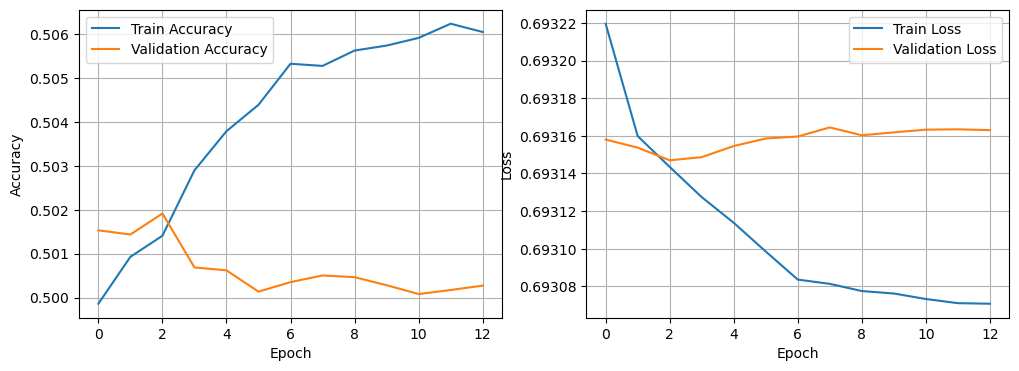

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Shape of y_val: (20, 128, 128, 1)
Shape of y_pred_val: (20, 128, 128)


ValueError: Shape mismatch before flattening: masks_actual has shape (20, 128, 128, 1), y_pred_val has shape (20, 128, 128)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the U-Net model
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[
        'accuracy'])

    return model

# Build the model
model = unet_model()

# Display the model summary
model.summary()

# Load your dataset here
# Assuming X_train, y_train, X_val, y_val are your dataset arrays
# Replace the following lines with your dataset loading code
X_train = np.random.rand(100, 128, 128, 3)  # Example placeholder data
y_train = np.random.randint(0, 2, (100, 128, 128, 1))  # Example placeholder data
X_val = np.random.rand(20, 128, 128, 3)  # Example placeholder data
y_val = np.random.randint(0, 2, (20, 128, 128, 1))  # Example placeholder data

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model-unet.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

# Save the final model
model.save('unet_unaugmented_model.keras')

# Plot the training and validation accuracy and loss at each epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Calculate metrics on validation data
y_pred_val = model.predict(X_val)
y_pred_val = y_pred_val.squeeze()  # Remove any extra dimensions

# Apply threshold to get binary predictions
y_pred_val = (y_pred_val > 0.5).astype(int)

# Ensure masks_actual is also binary
masks_actual = (y_val > 0.5).astype(int)

# Print shapes for debugging before flattening
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_pred_val: {y_pred_val.shape}")

# Ensure masks have the same shape
if masks_actual.shape != y_pred_val.shape:
    raise ValueError(f"Shape mismatch before flattening: masks_actual has shape {masks_actual.shape}, y_pred_val has shape {y_pred_val.shape}")

# Flatten masks
masks_actual = masks_actual.flatten()
masks_pred = y_pred_val.flatten()

# Print shapes for debugging after flattening
print(f"Shape of masks_actual: {masks_actual.shape}")
print(f"Shape of masks_pred: {masks_pred.shape}")

# Check if lengths match
if masks_actual.shape[0] != masks_pred.shape[0]:
    raise ValueError(f"Shape mismatch: masks_actual has {masks_actual.shape[0]} elements, masks_pred has {masks_pred.shape[0]} elements")

# Calculate the metrics
accuracy = accuracy_score(masks_actual, masks_pred) * 100
precision = precision_score(masks_actual, masks_pred, zero_division=1) * 100
recall = recall_score(masks_actual, masks_pred) * 100
f1 = f1_score(masks_actual, masks_pred) * 100

# Confusion matrix components
tn, fp, fn, tp = confusion_matrix(masks_actual, masks_pred).ravel()

# Specificity calculation
specificity = (tn / (tn + fp + np.finfo(float).eps)) * 100

# Dice coefficient calculation
dice = (2 * np.sum(masks_actual * masks_pred) / (np.sum(masks_actual) + np.sum(masks_pred) + np.finfo(float).eps)) * 100

# Sensitivity is the same as recall
sensitivity = recall

metrics = pd.DataFrame({
    'Metrics For Validation Data': ['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Specificity', 'Dice Score', 'Sensitivity'],
    'Value': [accuracy, precision, recall, f1, specificity, dice, sensitivity]
})

print(metrics)


In [5]:
# Calculate metrics on validation data
y_pred_val = model.predict(X_val)
y_pred_val = y_pred_val.squeeze()  # Remove any extra dimensions

# Apply threshold to get binary predictions
y_pred_val = (y_pred_val > 0.5).astype(int)

# Ensure masks_actual is also binary
masks_actual = (y_val > 0.5).astype(int)

# Reshape y_pred_val to match the shape of y_val
y_pred_val = np.expand_dims(y_pred_val, axis=-1)

# Print shapes for debugging before flattening
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_pred_val: {y_pred_val.shape}")

# Ensure masks have the same shape
if masks_actual.shape != y_pred_val.shape:
    raise ValueError(f"Shape mismatch before flattening: masks_actual has shape {masks_actual.shape}, y_pred_val has shape {y_pred_val.shape}")

# Flatten masks
masks_actual = masks_actual.flatten()
masks_pred = y_pred_val.flatten()

# Print shapes for debugging after flattening
print(f"Shape of masks_actual: {masks_actual.shape}")
print(f"Shape of masks_pred: {masks_pred.shape}")

# Check if lengths match
if masks_actual.shape[0] != masks_pred.shape[0]:
    raise ValueError(f"Shape mismatch: masks_actual has {masks_actual.shape[0]} elements, masks_pred has {masks_pred.shape[0]} elements")

# Calculate the metrics
accuracy = accuracy_score(masks_actual, masks_pred) * 100
precision = precision_score(masks_actual, masks_pred, zero_division=1) * 100
recall = recall_score(masks_actual, masks_pred) * 100
f1 = f1_score(masks_actual, masks_pred) * 100

# Confusion matrix components
tn, fp, fn, tp = confusion_matrix(masks_actual, masks_pred).ravel()

# Specificity calculation
specificity = (tn / (tn + fp + np.finfo(float).eps)) * 100

# Dice coefficient calculation
dice = (2 * np.sum(masks_actual * masks_pred) / (np.sum(masks_actual) + np.sum(masks_pred) + np.finfo(float).eps)) * 100

# Sensitivity is the same as recall
sensitivity = recall

metrics = pd.DataFrame({
    'Metrics For Validation Data': ['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Specificity', 'Dice Score', 'Sensitivity'],
    'Value': [accuracy, precision, recall, f1, specificity, dice, sensitivity]
})

print(metrics)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Shape of y_val: (20, 128, 128, 1)
Shape of y_pred_val: (20, 128, 128, 1)
Shape of masks_actual: (327680,)
Shape of masks_pred: (327680,)
  Metrics For Validation Data      Value
0              Accuracy Score  50.027161
1             Precision Score  49.966703
2                Recall Score  56.402327
3                    F1 Score  52.989829
4                 Specificity  43.668471
5                  Dice Score  52.989829
6                 Sensitivity  56.402327


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


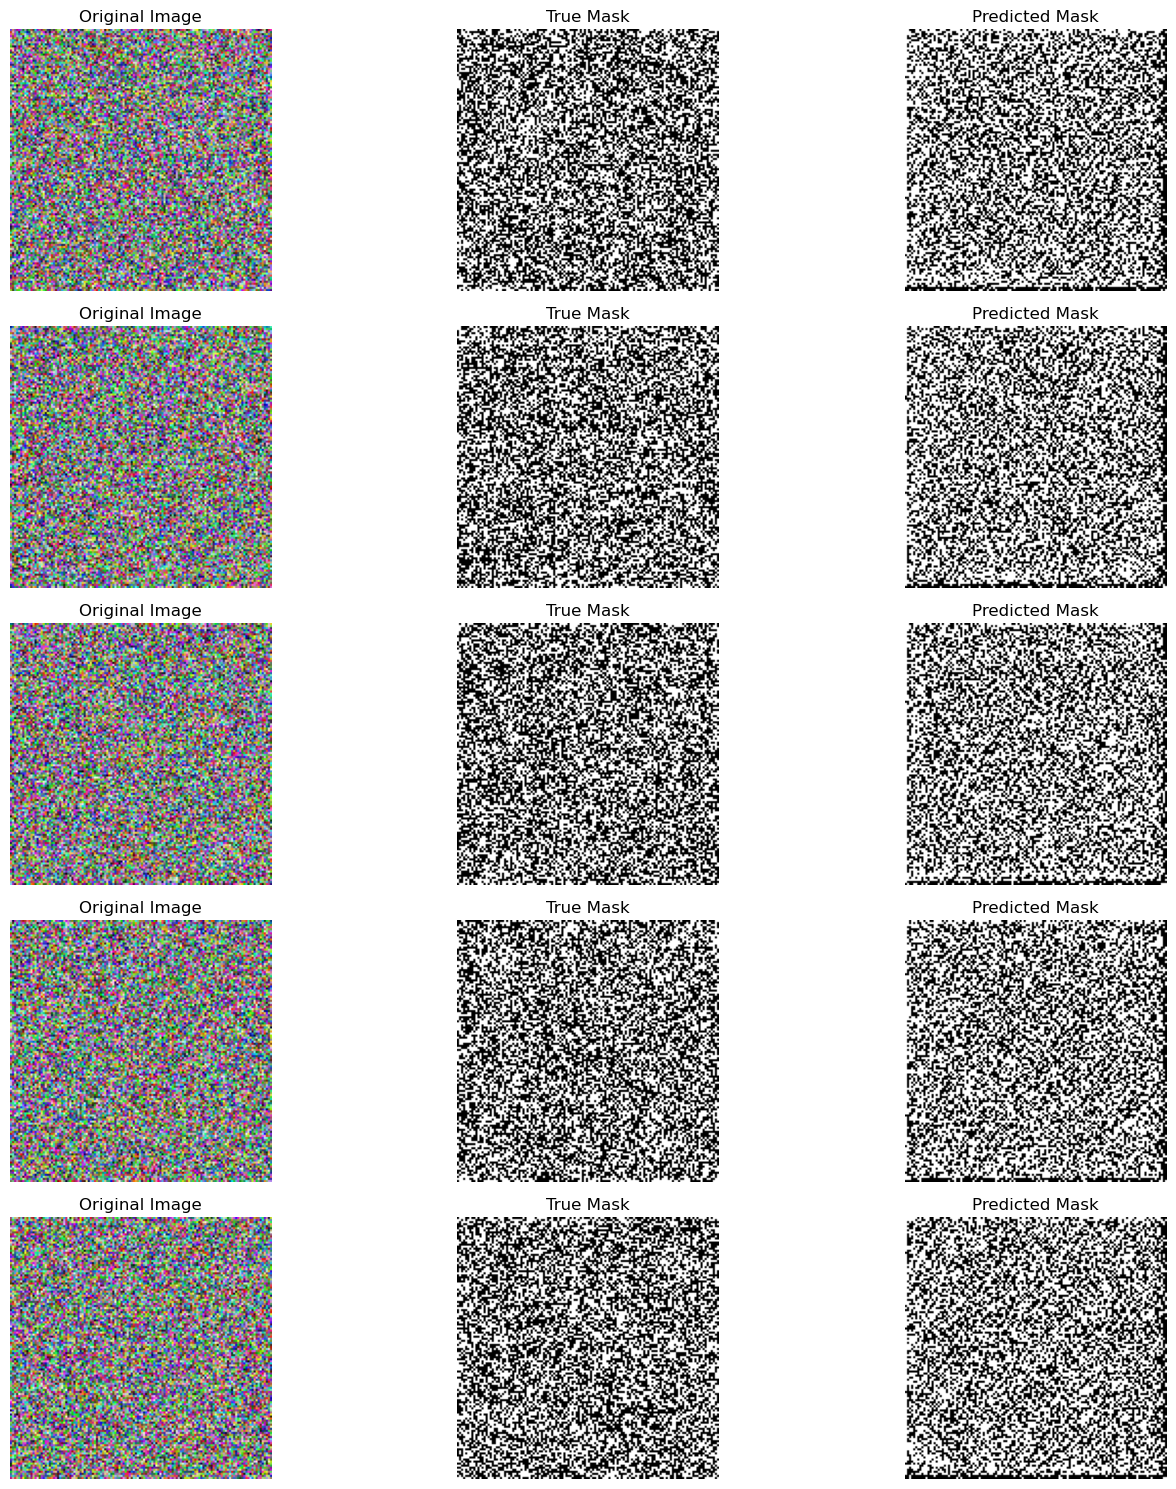

In [6]:
import matplotlib.pyplot as plt

# Function to display a set of images, their actual masks, and predicted masks
def display_predictions(X, y_true, y_pred, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        idx = np.random.randint(0, X.shape[0])

        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[idx])
        plt.title('Original Image')
        plt.axis('off')

        # True mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_true[idx].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(y_pred[idx].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Predict on the validation data
y_pred_val = model.predict(X_val)
y_pred_val = (y_pred_val > 0.5).astype(int)  # Apply threshold to get binary predictions

# Display sample predictions
display_predictions(X_val, y_val, y_pred_val, num_samples=5)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.4599 - loss: 1.2468 - val_accuracy: 0.5385 - val_loss: 1.0128 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 785ms/step - accuracy: 0.5627 - loss: 0.9937 - val_accuracy: 0.5385 - val_loss: 1.0088 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 604ms/step - accuracy: 0.5703 - loss: 0.9812 - val_accuracy: 0.5385 - val_loss: 1.0052 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5303 - loss: 1.0098 - val_accuracy: 0.5385 - val_loss: 1.0101 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5769 - loss: 0.9667 - val_accuracy: 0.5385 - val_loss: 1.0100 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 316ms/step - accuracy: 0.5819 - loss: 0.9636 - val_accuracy: 0.5385 - val_loss: 1.0023 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 504ms/step - accuracy: 0.5702 - loss: 0.9763 -

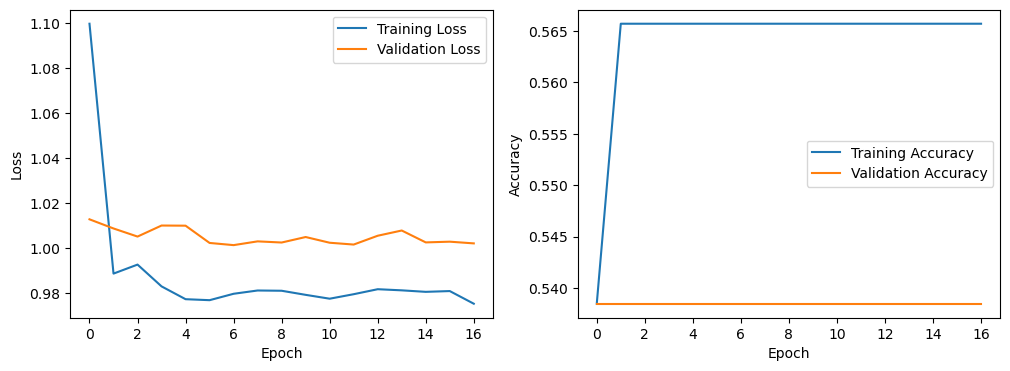

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
Accuracy Score: 53.85
Precision Score: 28.99
Recall Score: 53.85
F1 Score: 37.69
Specificity: nan
Dice Score: 37.69
Sensitivity: 53.85


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

def load_images_and_labels(base_data_dir, sub_dirs, img_size=(128, 128)):
    images = []
    labels = []
    
    for label, sub_dir in enumerate(sub_dirs):
        data_dir = os.path.join(base_data_dir, sub_dir)
        
        if not os.path.exists(data_dir):
            print(f"Directory {data_dir} not found")
            continue
        
        files = sorted(os.listdir(data_dir))
        
        for file in files:
            if '_mask' in file:
                continue
            img_path = os.path.join(data_dir, file)
            
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

# Load the images and labels from all subdirectories
dataset_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
sub_dirs = ['benign', 'malignant', 'normal']
images, labels = load_images_and_labels(dataset_dir, sub_dirs)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

def build_unet_classification_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Flatten for classification
    f = Flatten()(c5)
    d1 = Dense(512, activation='relu')(f)
    d2 = Dense(256, activation='relu')(d1)
    d3 = Dense(128, activation='relu')(d2)
    outputs = Dense(num_classes, activation='softmax')(d3)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = X_train.shape[1:]
num_classes = len(sub_dirs)
model = build_unet_classification_model(input_shape, num_classes)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_unet_classification_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predict the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred_classes)
precision = precision_score(y_val, y_pred_classes, average='weighted')
recall = recall_score(y_val, y_pred_classes, average='weighted')
f1 = f1_score(y_val, y_pred_classes, average='weighted')

# Calculate confusion matrix to derive specificity and sensitivity
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Ensure the confusion matrix has the correct shape
if conf_matrix.shape == (2, 2):
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall  # Sensitivity is the same as recall for the positive class
else:
    specificity = np.nan
    sensitivity = recall

# Dice score is typically used for segmentation, but for classification, it's the same as F1 score
dice_score = f1

# Display the metrics
print(f"Accuracy Score: {accuracy * 100:.2f}")
print(f"Precision Score: {precision * 100:.2f}")
print(f"Recall Score: {recall * 100:.2f}")
print(f"F1 Score: {f1 * 100:.2f}")
print(f"Specificity: {specificity * 100:.2f}")
print(f"Dice Score: {dice_score * 100:.2f}")
print(f"Sensitivity: {sensitivity * 100:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


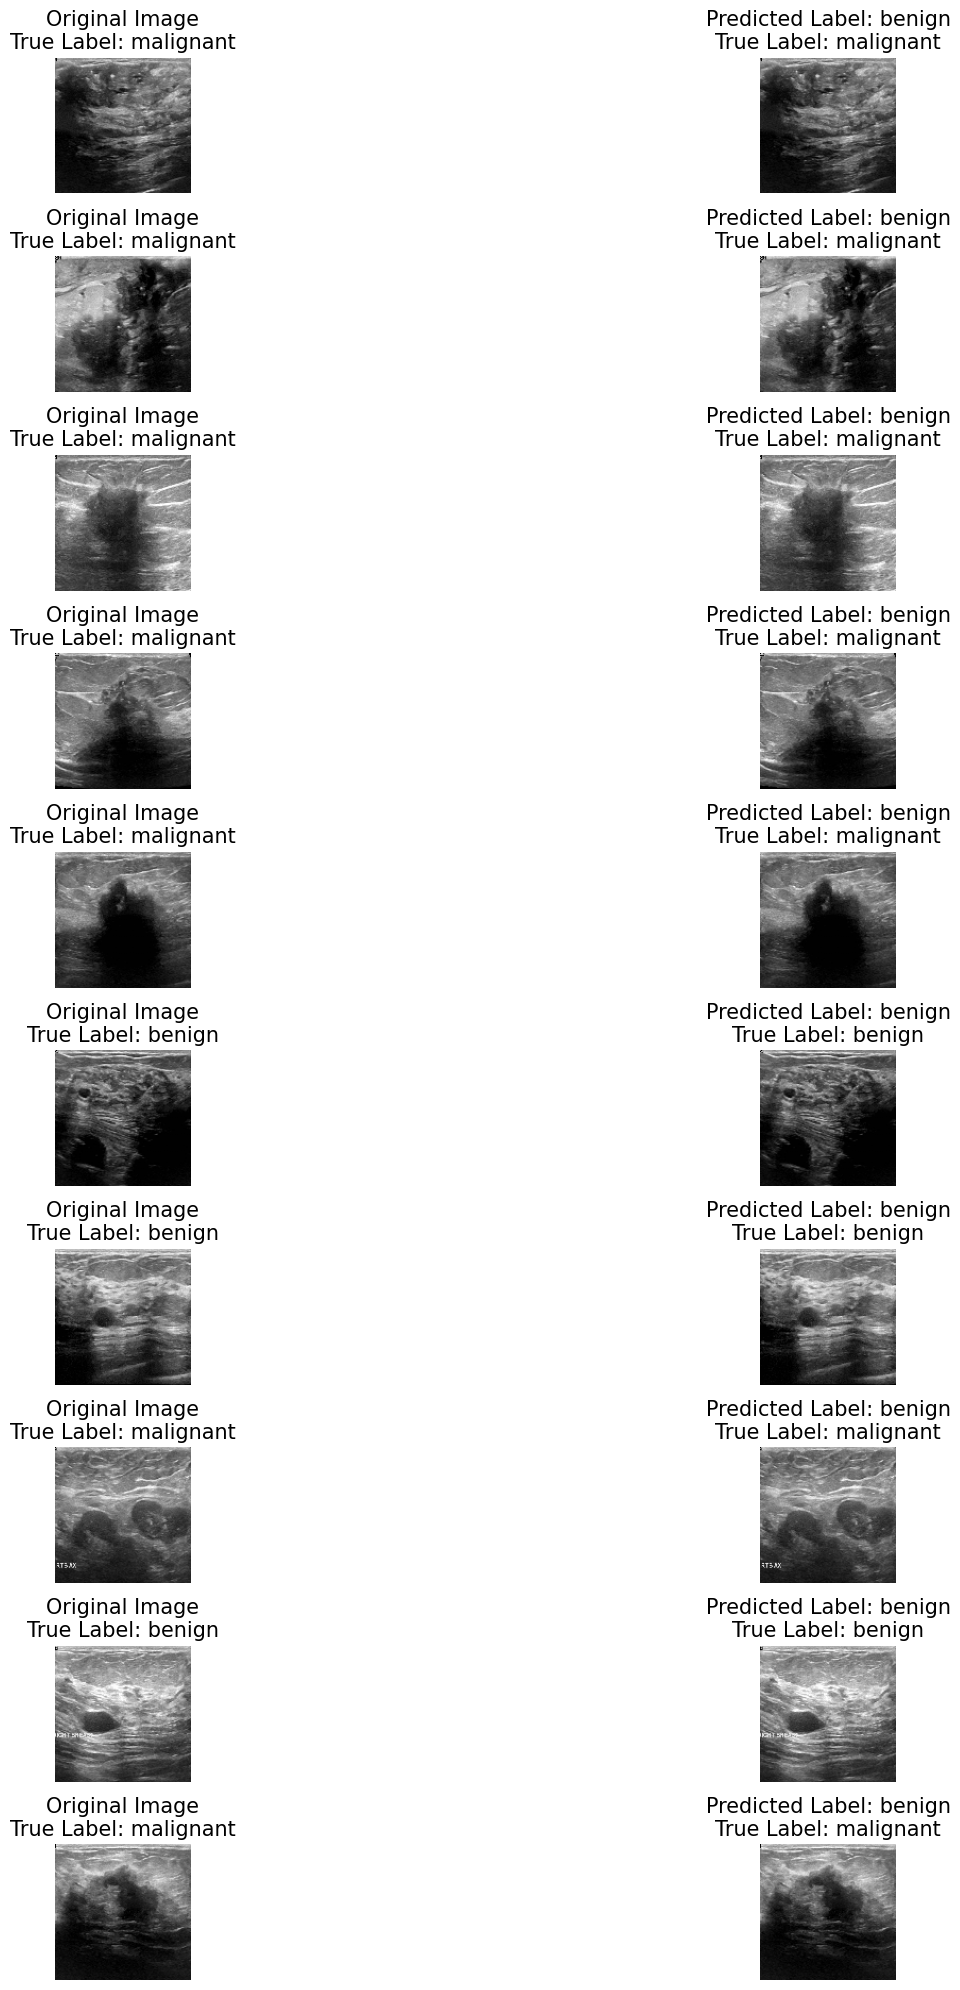

In [11]:
import matplotlib.pyplot as plt

# Define the class names
class_names = ['benign', 'malignant', 'normal']

def visualize_predictions(X_val, y_val, y_pred_classes, class_names, num_images=10):
    """
    Visualize the original images along with their predicted and true labels.

    Parameters:
    X_val (np.array): Validation images.
    y_val (np.array): True labels of the validation images.
    y_pred_classes (np.array): Predicted labels of the validation images.
    class_names (list): List of class names corresponding to labels.
    num_images (int): Number of images to visualize.
    """
    plt.figure(figsize=(20, 20))
    
    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(X_val[i])
        true_label = class_names[y_val[i]]
        plt.title(f'Original Image\nTrue Label: {true_label}', fontsize=15)
        plt.axis('off')
        
        # Predicted image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(X_val[i])
        predicted_label = class_names[y_pred_classes[i]]
        plt.title(f'Predicted Label: {predicted_label}\nTrue Label: {true_label}', fontsize=15)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Predict the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Visualize predictions
visualize_predictions(X_val, y_val, y_pred_classes, class_names, num_images=10)
